# STEP 4: Differential Privacy - DP-SGD Defense
## CIS545 Privacy-Preserving Cognitive Twin Project

**Lead**: Alwaleed Alalami (DP-SGD Defense Lead)

**Objective**: Train differentially private models with varying privacy budgets (ε). Evaluate privacy-utility tradeoff.

**Inputs**:
- `X_train.csv`, `X_val.csv`, `X_test.csv` - Training, validation, test data
- `y_train.csv`, `y_val.csv`, `y_test.csv` - Labels
- `attack_results.json` - Baseline attack metrics (for comparison)

**Outputs**:
- `dp_models/` - Trained DP models for each epsilon
- `dp_results.json` - Performance metrics (accuracy, F1, AUROC) for each epsilon
- `privacy_utility_frontier.png` - Key visualization
- `dp_analysis.md` - Findings & recommendations

**Timeline**: 30-60 minutes

---

## Part 0: Setup & Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# For DP-SGD, we'll use a neural network approach
# Install if needed: pip install opacus torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Opacus for DP-SGD
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager

# Set random seeds (FROZEN)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Device
# Device - Force CPU due to CUDA compatibility issues
device = torch.device('cpu')

## Part 1: Load & Prepare Data

In [2]:
# Load data
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')

y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')

# Drop non-numeric columns (CRITICAL: Match Kevin's preprocessing)
cols_to_drop = ['Subject', 'Label']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

# Extract labels (capital 'L' to match Kevin's preprocessing)
y_train_labels = y_train['Label'].values
y_val_labels = y_val['Label'].values
y_test_labels = y_test['Label'].values

# Ensure numeric labels
y_train_labels = y_train_labels.astype(int)
y_val_labels = y_val_labels.astype(int)
y_test_labels = y_test_labels.astype(int)

# Get number of classes
num_classes = len(np.unique(y_train_labels))

print(f"✓ Data loaded")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")
print(f"  Classes: {np.unique(y_train_labels)}")
print(f"  Number of classes: {num_classes}")

✓ Data loaded
  Train: (1140, 84)
  Val: (97, 84)
  Test: (190, 84)
  Classes: [0 1 2 3]
  Number of classes: 4


In [3]:
# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train_labels).to(device)

X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.LongTensor(y_val_labels).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test_labels).to(device)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print(f"✓ Data scaled and converted to tensors")

✓ Data scaled and converted to tensors


## Part 2: Define Neural Network Model

In [4]:
class SimpleNeuralNet(nn.Module):
    """Simple neural network for classification."""
    def __init__(self, input_dim, hidden_dim=64, num_classes=4, dropout_p=0.2):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Test model
model = SimpleNeuralNet(X_train.shape[1], hidden_dim=64, num_classes=num_classes)
model = model.to(device)
print(f"✓ Model defined")
print(model)

✓ Model defined
SimpleNeuralNet(
  (fc1): Linear(in_features=84, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


## Part 3: Training Function

In [5]:
def train_model(model, train_loader, val_loader, optimizer, criterion, privacy_engine=None, epochs=50):
    """
    Train model with optional differential privacy.
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer
        criterion: Loss function
        privacy_engine: Opacus PrivacyEngine (None for non-private training)
        epochs: Number of epochs
    
    Returns:
        Trained model, training history
    """
    train_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                logits = model(X_batch)
                _, predicted = torch.max(logits, 1)
                val_correct += (predicted == y_batch).sum().item()
                val_total += y_batch.size(0)
        
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        
        if privacy_engine:
            epsilon = privacy_engine.get_epsilon(delta=1e-5)
            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1:3d}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Epsilon={epsilon:.4f}")
        else:
            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1:3d}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}")
    
    return model, {'train_loss': train_losses, 'val_acc': val_accs}

print("✓ Training function defined")

✓ Training function defined


## Part 4: Evaluation Function

In [6]:
import scipy.special

def evaluate_model(model, test_loader):
    """
    Evaluate model on test set.
    
    Returns:
        Metrics dictionary
    """
    model.eval()
    
    all_logits = []
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            logits = model(X_batch)
            _, predicted = torch.max(logits, 1)
            
            all_logits.append(logits.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    predictions = np.concatenate(all_predictions)
    labels = np.concatenate(all_labels)
    logits = np.concatenate(all_logits)
    probs = scipy.special.softmax(logits, axis=1)
    
    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    
    # F1 score (macro)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    
    # AUROC (macro)
    try:
        auroc_macro = roc_auc_score(labels, probs, multi_class='ovr', average='macro')
    except:
        auroc_macro = 0.0
    
    # Expected Calibration Error
    max_probs = np.max(probs, axis=1)
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0
    for i in range(n_bins):
        mask = (max_probs >= bin_boundaries[i]) & (max_probs < bin_boundaries[i+1])
        if mask.sum() > 0:
            avg_confidence = max_probs[mask].mean()
            accuracy_in_bin = (predictions[mask] == labels[mask]).mean()
            ece += abs(avg_confidence - accuracy_in_bin) * mask.sum() / len(labels)
    
    return {
        'accuracy': float(accuracy),
        'f1_macro': float(f1_macro),
        'auroc_macro': float(auroc_macro),
        'ece': float(ece),
        'predictions': predictions,
        'probs': probs
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


## Part 5: Train Models with Different Epsilon Values

**Epsilon sweep**: {∞, 8, 4, 2, 1}

- ε=∞: No privacy (baseline)
- ε=8: Very high privacy budget (high utility)
- ε=4: High privacy budget (good utility)
- ε=2: Medium privacy budget (moderate utility)
- ε=1: Low privacy budget (low utility, maximum privacy)

In [7]:
# Configuration
EPSILON_VALUES = [float('inf'), 8, 4, 2, 1]
DELTA = 1e-5  # FROZEN
BATCH_SIZE = 32
EPOCHS = 50
LR = 0.001

# DP-SGD specific parameters
MAX_GRAD_NORM = 1.0  # Gradient clipping
NOISE_MULTIPLIER_MAP = {
    float('inf'): 0.0,  # No noise
    8: 0.5,
    4: 1.0,
    2: 1.5,
    1: 2.0
}

dp_results = {}
dp_models = {}

print(f"Training models with epsilon sweep: {EPSILON_VALUES}")
print(f"Delta (fixed): {DELTA}")
print(f"Gradient clipping norm: {MAX_GRAD_NORM}")
print()

Training models with epsilon sweep: [inf, 8, 4, 2, 1]
Delta (fixed): 1e-05
Gradient clipping norm: 1.0



In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU

# Then in Part 0:
device = torch.device('cpu')  # Force CPU
print(f"✓ Device: {device} (CPU mode - GPU not compatible)")

✓ Device: cpu (CPU mode - GPU not compatible)


In [9]:
for epsilon in EPSILON_VALUES:
    print(f"\n{'='*60}")
    print(f"Training DP model with epsilon = {epsilon}")
    print(f"{'='*60}")
    
    # Create fresh model
    model = SimpleNeuralNet(X_train.shape[1], hidden_dim=64, num_classes=num_classes)
    model = model.to(device)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Setup optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    # Setup DP if epsilon != infinity
    privacy_engine = None
    if epsilon != float('inf'):
        privacy_engine = PrivacyEngine()
        
        noise_multiplier = NOISE_MULTIPLIER_MAP[epsilon]
        print(f"Noise multiplier: {noise_multiplier}")
        print(f"Gradient clipping norm: {MAX_GRAD_NORM}")
        
        model, optimizer, train_loader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier=noise_multiplier,
            max_grad_norm=MAX_GRAD_NORM
        )
    
    # Train model - FIXED: Pass arguments correctly
    print(f"Training for {EPOCHS} epochs...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        privacy_engine=privacy_engine,
        epochs=EPOCHS
    )
    
    # Evaluate on test set
    print(f"\nEvaluating on test set...")
    test_metrics = evaluate_model(model, test_loader)
    
    # Store results
    dp_models[str(epsilon)] = model
    dp_results[str(epsilon)] = {
        'epsilon': float(epsilon) if epsilon != float('inf') else 'inf',
        'delta': DELTA,
        'metrics': {
            'accuracy': test_metrics['accuracy'],
            'f1_macro': test_metrics['f1_macro'],
            'auroc_macro': test_metrics['auroc_macro'],
            'ece': test_metrics['ece']
        },
        'privacy_params': {
            'max_grad_norm': MAX_GRAD_NORM,
            'noise_multiplier': float(NOISE_MULTIPLIER_MAP[epsilon])
        }
    }
    
    print(f"\nResults for epsilon={epsilon}:")
    print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"  F1 (macro): {test_metrics['f1_macro']:.4f}")
    print(f"  AUROC (macro): {test_metrics['auroc_macro']:.4f}")
    print(f"  ECE: {test_metrics['ece']:.4f}")

print(f"\n✓ All models trained")


Training DP model with epsilon = inf
Training for 50 epochs...
  Epoch  10: Loss=0.4840, Val Acc=0.7732
  Epoch  20: Loss=0.3761, Val Acc=0.7320
  Epoch  30: Loss=0.2870, Val Acc=0.6804
  Epoch  40: Loss=0.2379, Val Acc=0.7113
  Epoch  50: Loss=0.1994, Val Acc=0.7526

Evaluating on test set...

Results for epsilon=inf:
  Accuracy:  0.5684
  F1 (macro): 0.2980
  AUROC (macro): 0.6823
  ECE: 0.3191

Training DP model with epsilon = 8
Noise multiplier: 0.5
Gradient clipping norm: 1.0
Training for 50 epochs...
  Epoch  10: Loss=1.2676, Val Acc=0.6082, Epsilon=19.9363
  Epoch  20: Loss=1.0617, Val Acc=0.6082, Epsilon=27.8283
  Epoch  30: Loss=0.9088, Val Acc=0.6598, Epsilon=34.5094
  Epoch  40: Loss=0.9326, Val Acc=0.7423, Epsilon=40.5666
  Epoch  50: Loss=0.8390, Val Acc=0.7423, Epsilon=46.2258

Evaluating on test set...

Results for epsilon=8:
  Accuracy:  0.6579
  F1 (macro): 0.3465
  AUROC (macro): 0.6514
  ECE: 0.2111

Training DP model with epsilon = 4
Noise multiplier: 1.0
Gradient 

## Part 6: Privacy-Utility Frontier Visualization

✓ Saved: privacy_utility_frontier.png


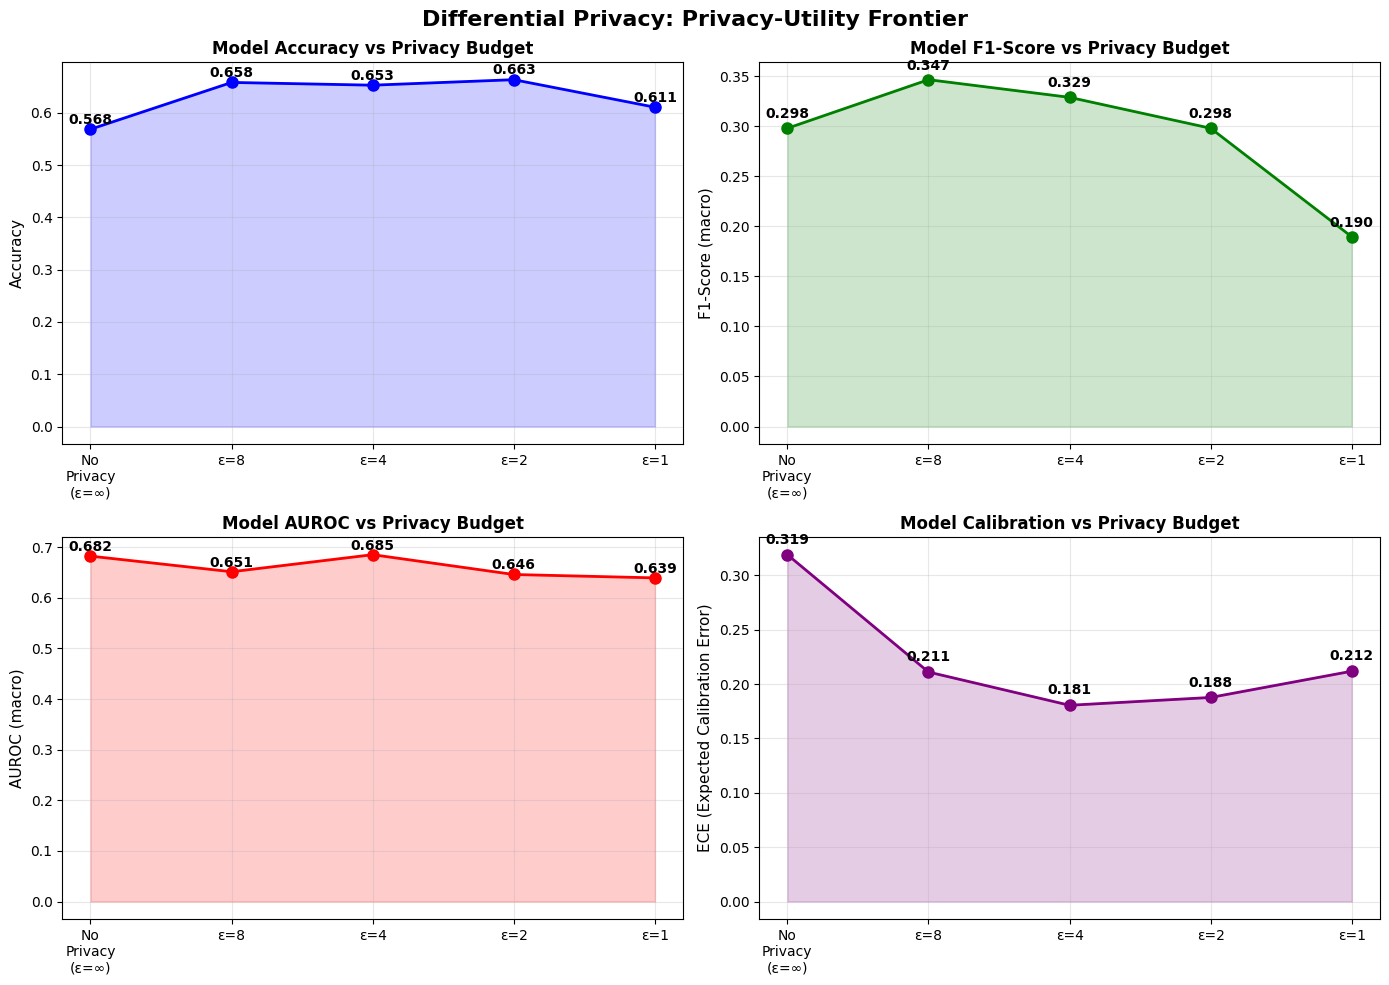

In [10]:
# Extract results for plotting
epsilon_vals = []
accuracy_vals = []
f1_vals = []
auroc_vals = []
ece_vals = []

for eps_str in ['inf', '8', '4', '2', '1']:
    if eps_str in dp_results:
        result = dp_results[eps_str]
        epsilon_vals.append('∞' if eps_str == 'inf' else float(eps_str))
        accuracy_vals.append(result['metrics']['accuracy'])
        f1_vals.append(result['metrics']['f1_macro'])
        auroc_vals.append(result['metrics']['auroc_macro'])
        ece_vals.append(result['metrics']['ece'])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Differential Privacy: Privacy-Utility Frontier', fontsize=16, fontweight='bold')

# Prepare epsilon labels for x-axis
epsilon_labels = []
for i, eps in enumerate(epsilon_vals):
    if eps == '∞':
        epsilon_labels.append('No\nPrivacy\n(ε=∞)')
    else:
        epsilon_labels.append(f'ε={int(eps)}')

# Accuracy vs Privacy
ax = axes[0, 0]
ax.plot(range(len(epsilon_labels)), accuracy_vals, 'o-', linewidth=2, markersize=8, color='blue')
ax.fill_between(range(len(epsilon_labels)), accuracy_vals, alpha=0.2, color='blue')
ax.set_xticks(range(len(epsilon_labels)))
ax.set_xticklabels(epsilon_labels, fontsize=10)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Model Accuracy vs Privacy Budget', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, v in enumerate(accuracy_vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# F1 vs Privacy
ax = axes[0, 1]
ax.plot(range(len(epsilon_labels)), f1_vals, 'o-', linewidth=2, markersize=8, color='green')
ax.fill_between(range(len(epsilon_labels)), f1_vals, alpha=0.2, color='green')
ax.set_xticks(range(len(epsilon_labels)))
ax.set_xticklabels(epsilon_labels, fontsize=10)
ax.set_ylabel('F1-Score (macro)', fontsize=11)
ax.set_title('Model F1-Score vs Privacy Budget', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, v in enumerate(f1_vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# AUROC vs Privacy
ax = axes[1, 0]
ax.plot(range(len(epsilon_labels)), auroc_vals, 'o-', linewidth=2, markersize=8, color='red')
ax.fill_between(range(len(epsilon_labels)), auroc_vals, alpha=0.2, color='red')
ax.set_xticks(range(len(epsilon_labels)))
ax.set_xticklabels(epsilon_labels, fontsize=10)
ax.set_ylabel('AUROC (macro)', fontsize=11)
ax.set_title('Model AUROC vs Privacy Budget', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, v in enumerate(auroc_vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# ECE (Calibration) vs Privacy
ax = axes[1, 1]
ax.plot(range(len(epsilon_labels)), ece_vals, 'o-', linewidth=2, markersize=8, color='purple')
ax.fill_between(range(len(epsilon_labels)), ece_vals, alpha=0.2, color='purple')
ax.set_xticks(range(len(epsilon_labels)))
ax.set_xticklabels(epsilon_labels, fontsize=10)
ax.set_ylabel('ECE (Expected Calibration Error)', fontsize=11)
ax.set_title('Model Calibration vs Privacy Budget', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, v in enumerate(ece_vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('privacy_utility_frontier.png', dpi=300, bbox_inches='tight')
print("✓ Saved: privacy_utility_frontier.png")
plt.show()

## Part 7: Save Results

In [11]:
# Save DP results
with open('dp_results.json', 'w') as f:
    json.dump(dp_results, f, indent=2)

print("✓ Saved: dp_results.json")
print()
print(json.dumps(dp_results, indent=2))

✓ Saved: dp_results.json

{
  "inf": {
    "epsilon": "inf",
    "delta": 1e-05,
    "metrics": {
      "accuracy": 0.5684210526315789,
      "f1_macro": 0.29798290902617053,
      "auroc_macro": 0.6822757402989336,
      "ece": 0.3190744447080713
    },
    "privacy_params": {
      "max_grad_norm": 1.0,
      "noise_multiplier": 0.0
    }
  },
  "8": {
    "epsilon": 8.0,
    "delta": 1e-05,
    "metrics": {
      "accuracy": 0.6578947368421053,
      "f1_macro": 0.3465163308913309,
      "auroc_macro": 0.6514458558629828,
      "ece": 0.21112054194274704
    },
    "privacy_params": {
      "max_grad_norm": 1.0,
      "noise_multiplier": 0.5
    }
  },
  "4": {
    "epsilon": 4.0,
    "delta": 1e-05,
    "metrics": {
      "accuracy": 0.6526315789473685,
      "f1_macro": 0.3288682201890512,
      "auroc_macro": 0.6851353542211838,
      "ece": 0.18054176537614122
    },
    "privacy_params": {
      "max_grad_norm": 1.0,
      "noise_multiplier": 1.0
    }
  },
  "2": {
    "epsilo